# Steps

1. ## Import SVHN dataset
2. ## Data preprocessing
   - Check data type
   - Convert to float for image and to int for label
   - Normalize the data
   - One-hot encoding for labels
   - Data augmentation
      > augment the images in the dataset, by randomly rotating them, zooming them in and out, shifting them up and down
 
 <br>
 
 3. ## Create CNN model

 4. ## Train & Test

 5. ## Results and discussion


## PLEASE RUN FROM HERE

## Step 1: Import SVHN dataset

In [1]:
import h5py
import torchvision
import torchvision.transforms as transforms
import cv2
import os
import numpy as np
import glob
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import matplotlib.image as img

In [2]:
# local_path = "../.." <- please change dir here
local_path = "C:/Users/kaili/OneDrive/Desktop/CS6140 ML/Project Dataset/"

## Step 2: Data Preprocessing

### 2a. Crop Images and Convert to grayscale

In [3]:
# following class are used for image crop and get cropped image path 
class CropImage(object):
    def __init__ (self, local_path, mode, grayscale=True):
        # load digitStruct.mat
        self.local_path = local_path
        self.mode = mode
        self.grayscale = grayscale
        if mode == "train":
            self.f = h5py.File(local_path + "/train/digitStruct.mat", 'r')
        elif mode == "test":
            self.f = h5py.File(local_path + "/test/digitStruct.mat", 'r')
        # get dataset for each group
        self.digitStructName = self.f['digitStruct']['name']
        self.digitStructBbox = self.f['digitStruct']['bbox']
        self.file_path_dict = {}
        
    # get bbox for each instance. bbox is a library describing the bounder box position
    def get_bbox(self, n):
        bbox = {}
        bb = self.digitStructBbox[n].item()
        def bbox_helper(attr_type):
            attr = self.f[bb][attr_type]
            if len(attr) > 1:
                pos = [int(self.f[attr[j].item()][0][0]) for j in range(len(attr))]
            else:
                pos = [attr[0][0]]

            return pos
        bbox['label'] = bbox_helper('label')
        bbox['height'] = bbox_helper('height')
        bbox['left'] = bbox_helper('left')
        bbox['top'] = bbox_helper('top')
        bbox['width'] = bbox_helper('width')
        return bbox

    # get file name for each instance. File names are indexes starting from 1
    def get_name(self, n):
        name = ''.join([chr(v[0]) for v in self.f[(self.digitStructName[n][0])]])
        return name

    def save_path_to_dict(self, original_file_name, save_file_path, img):
        # save path to dict
        if original_file_name not in self.file_path_dict:
            self.file_path_dict[original_file_name] = [save_file_path]
        elif save_file_path not in self.file_path_dict[original_file_name]:
            self.file_path_dict[original_file_name].append(save_file_path)
        # save cropped image
        torchvision.utils.save_image(img, save_file_path)

    # crop image for each instance, also save cropped image name to the dict
    def crop_image(self, n):
        n_drop = 0
        # for each label, crop the image
        digit_dict = self.get_bbox(n)
        
        for label_index in range(len(digit_dict['label'])):
            label = int(digit_dict['label'][label_index])
            # label 0 is represented using 10
            if label == 10:
                label = 0

            # get crop position
            left = int(digit_dict['left'][label_index])
            upper = int(digit_dict['top'][label_index])
            right = int(left + digit_dict['width'][label_index])
            lower = int(upper + digit_dict['height'][label_index])

            # invalid data
            if left < 0 or upper < 0:
                n_drop += 1
                continue

            # crop image
            img_path_crop_test = self.local_path + '/' + self.mode + '/' + self.get_name(n)
            image = cv2.imread(img_path_crop_test)
            img = image[upper:lower, left:right, :]

            if self.grayscale == True:
                # transpose image into size 32 * 32 grayscale tensor format
                transformed_img = transforms.Compose(
                        [transforms.ToPILImage(),
                        transforms.Grayscale(num_output_channels=1),
                        transforms.Resize((32, 32)),
                        transforms.ToTensor()])(img)
                # ref: http://man.hubwiz.com/docset/torchvision.docset/Contents/Resources/Documents/transforms.html
            else:
                 # If num_output_channels == 1 : returned image is single channel If num_output_channels == 3 : returned image is 3 channel with r == g == b
                transformed_img = transforms.Compose(
                        [transforms.ToPILImage(),
                        transforms.Resize((32, 32)),
                        transforms.ToTensor()])(img)

            grayscale_text = 'single' if self.grayscale == True else 'rgb'
            process_folder = self.local_path + '/process/' + self.mode + '/' + grayscale_text +'/'
            # check whether the process folder exists or not
            if not os.path.exists(process_folder):
                # create a new directory because it does not exist
                os.makedirs(process_folder)
                print("Created the process folder to store preprocessed images")

            # store image as original file name + _ + label + _ + label index, saved in process folder
            original_file_name = self.get_name(n).split('.')[0]

            file_head = '_'.join([process_folder + original_file_name, str(label_index), str(label)])
            file_tail = '.png'
            inverted_file_tail = '_iv.png'

            # invert grayscale image to get a new image, by doing so we could expande our training data set
            if self.mode == "train":
                inverted_transformed_img = transforms.functional.invert(transformed_img)
                self.save_path_to_dict(original_file_name, file_head+inverted_file_tail, inverted_transformed_img)
        
            self.save_path_to_dict(original_file_name, file_head+file_tail, transformed_img)
    
    # get a list of cropped image file path
    def get_cropped_image_path(self, n):
        curr_path = self.local_path + '/' + self.mode + '/'
        # check the file name is out of range, max is 33401 for train, 13065 for test
        if n + 1 not in self.file_path_dict:
            if n + 2 >= len(os.listdir(curr_path)): # changed from 3 to 2
                print("Please check the file name!")
            else:
                # havent been processed yet
                self.crop_image(n)
        # return a list of file path name of the cropped file 
        return self.file_path_dict[str(n+1)]

In [4]:
# test functionality
# replace "local_path" to your real local path before test, e.g. "/Users/evelynhsu/CS6140"
ci_train = CropImage(local_path=local_path, mode="train", grayscale=True)
ci_train.get_cropped_image_path(33401)
ci_test = CropImage(local_path=local_path, mode="test", grayscale=False)
ci_test.get_cropped_image_path(13067)
ci_test = CropImage(local_path=local_path, mode="test", grayscale=True)
ci_test.get_cropped_image_path(13067)

['C:/Users/kaili/OneDrive/Desktop/CS6140 ML/Project Dataset//process/test/single/13068_0_6.png',
 'C:/Users/kaili/OneDrive/Desktop/CS6140 ML/Project Dataset//process/test/single/13068_1_7.png']

### 2b. Create train and test datasets

In [5]:
def get_cropped_images(cropped_img_dir_list):
    '''
    Return a list of images of a single number
    e.g. Original image = 210, return image of 2, 1, 0
    '''
    output = []
    for cropped_img_dir in cropped_img_dir_list:
        output.append(cv2.imread(cropped_img_dir))
    return output

def get_labels(data, idx, multiplier=1):
    '''
    Return a list of labels. Convert label 10 -> 0
    '''
    output = []
    for l in data.get_bbox(idx)['label']:
        output += [0] * multiplier if l == 10 else [int(l)]* multiplier
    return output

def create_input(local_path, mode, grayscale): # <- possible a better function name?
    '''
    Return lists of train/test
    '''
    X, y, image_number = [], [], []
    data = CropImage(local_path, mode, grayscale)
    dataset_path = local_path + "/" + mode
    total_image_num = len(glob.glob1(dataset_path, "*.png"))

    for idx in range(total_image_num):
        try:
            cropped_img_dir_list = data.get_cropped_image_path(idx)
            # Two images per number in the train, and only one in the test
            multiplier = 2 if mode == "train" else 1

            # Check if number of Cropped img == number of labels
            if len(cropped_img_dir_list) != len(
                    data.get_bbox(idx)['label'] * multiplier):
                print(
                    "Skipped {}.png, Number of cropped image is inconsistent with labels"
                    .format(idx + 1))
                continue

            X += get_cropped_images(cropped_img_dir_list)
            y += get_labels(data, idx, multiplier)
            image_number += [idx] * len(cropped_img_dir_list)

        except:
            # Failed to crop image
            print("Skipped {}.png, No cropped image output".format(idx + 1))
            continue

    return np.array(X), np.array(y), np.array(image_number)

In [6]:
# Create grayscaled train and test datasets
X_train, y_train, image_train = create_input(local_path, mode="train", grayscale=True)
X_test, y_test, img_number = create_input(local_path, mode="test", grayscale=True)

Skipped 252.png, Number of cropped image is inconsistent with labels
Skipped 724.png, Number of cropped image is inconsistent with labels
Skipped 3100.png, Number of cropped image is inconsistent with labels
Skipped 5312.png, Number of cropped image is inconsistent with labels
Skipped 6877.png, No cropped image output
Skipped 9357.png, Number of cropped image is inconsistent with labels
Skipped 11861.png, No cropped image output
Skipped 13145.png, No cropped image output
Skipped 15125.png, Number of cropped image is inconsistent with labels
Skipped 18277.png, Number of cropped image is inconsistent with labels
Skipped 18393.png, Number of cropped image is inconsistent with labels
Skipped 19383.png, Number of cropped image is inconsistent with labels
Skipped 20540.png, Number of cropped image is inconsistent with labels
Skipped 20901.png, Number of cropped image is inconsistent with labels
Skipped 20915.png, Number of cropped image is inconsistent with labels
Skipped 22442.png, Number o

In [7]:
# Create *colored* train and test datasets ETA 33min
X_train_colored, y_train_colored, colored_train_num = create_input(local_path, mode="train", grayscale=False)
X_test_colored, y_test_colored, colored_test_num = create_input(local_path, mode="test", grayscale=False)

Skipped 252.png, Number of cropped image is inconsistent with labels
Skipped 724.png, Number of cropped image is inconsistent with labels
Skipped 3100.png, Number of cropped image is inconsistent with labels
Skipped 5312.png, Number of cropped image is inconsistent with labels
Skipped 6877.png, No cropped image output
Skipped 9357.png, Number of cropped image is inconsistent with labels
Skipped 11861.png, No cropped image output
Skipped 13145.png, No cropped image output
Skipped 15125.png, Number of cropped image is inconsistent with labels
Skipped 18277.png, Number of cropped image is inconsistent with labels
Skipped 18393.png, Number of cropped image is inconsistent with labels
Skipped 19383.png, Number of cropped image is inconsistent with labels
Skipped 20540.png, Number of cropped image is inconsistent with labels
Skipped 20901.png, Number of cropped image is inconsistent with labels
Skipped 20915.png, Number of cropped image is inconsistent with labels
Skipped 22442.png, Number o

## Step 3: Create CNN model

In [49]:
# Create CNN base model
cnn_model = models.Sequential()
'''
[1] convolution layer + [2] ReLU R(z) = max(0, z)
filters 32 -> detect 32 different/features in the image, filter size 3 x 3
'''
cnn_model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 3)))

'''
[3] pooling layer, looking for the max value in a 2 x 2 filter
down-sampling operations that reduces the dimensionality of the feature map
detect edges, corners
'''
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

'''
flattening - converting all the resultant 2d arrays from pooled feature map to a single long continuous linear vector
'''
cnn_model.add(layers.Flatten()) 
cnn_model.add(layers.Dense(64, activation='relu'))
'''
[4] fully connected layer to identify the numbers 
'''
cnn_model.add(layers.Dense(10, activation='softmax'))

cnn_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

### 3a. Choose the optimal number of epochs

In [41]:
# Create CNN base model
model_epoch_diff = models.Sequential()
model_epoch_diff.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 3)))
model_epoch_diff.add(layers.MaxPooling2D((2, 2)))
model_epoch_diff.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_epoch_diff.add(layers.MaxPooling2D((2, 2)))
model_epoch_diff.add(layers.Flatten()) 
model_epoch_diff.add(layers.Dense(64, activation='relu'))
model_epoch_diff.add(layers.Dense(10, activation='softmax'))
model_epoch_diff.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

def find_optimal_epoch(model, X_train, y_train, X_test, y_test, epoch_num):
    test_loss_list, test_accuracy_list, train_loss_list, train_accuracy_list = [],[],[],[]
    
    for _ in range(1, epoch_num + 1):
        h = model.fit(X_train, y_train, epochs=1)
        train_loss = h.history['loss']
        train_loss_list.append(train_loss)
        train_accuracy = h.history['accuracy']
        train_accuracy_list.append(train_accuracy)

        test_loss, test_accuracy = model.evaluate(X_test,y_test)
        test_loss_list.append(test_loss)
        test_accuracy_list.append(test_accuracy)
        
    return test_loss_list, test_accuracy_list, train_loss_list, train_accuracy_list

test_loss_list, test_accuracy_list, train_loss_list, train_accuracy_list = find_optimal_epoch(model_epoch_diff, X_train, y_train, X_test, y_test, 15)

813/813 [==============================] - 3s 4ms/step - loss: 0.5651 - accuracy: 0.8611


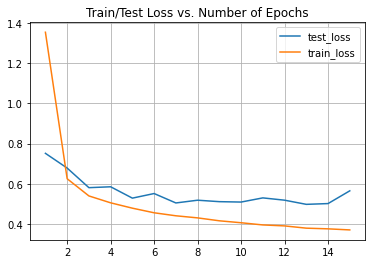

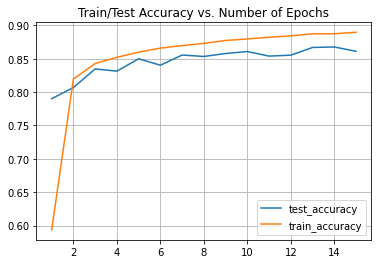

In [46]:
x = list(range(1, 16))
plt.plot(x, test_loss_list, label="test_loss") 
plt.plot(x, train_loss_list, label="train_loss") 
plt.legend()
plt.grid()
plt.title("Train/Test Loss vs. Number of Epochs")
plt.show()

plt.plot(x, test_accuracy_list, label="test_accuracy") 
plt.plot(x, train_accuracy_list, label="train_accuracy") 
plt.legend()
plt.grid()
plt.title("Train/Test Accuracy vs. Number of Epochs")
plt.show()

**Finding**
* Error rate increases when epoch >= 8
* Early stop to avoid overfitting. 
* As the number of epochs increases beyond 8, test loss increases depicting the overfitting of the model on training data.
* Choose epoch of 8
* Ref: https://www.geeksforgeeks.org/choose-optimal-number-of-epochs-to-train-a-neural-network-in-keras/

### 3b. Try different kernel sizes

##### Kernel size 3x3

In [58]:


# Try a kernel of 3x3 size in the convolutional layer to see if accuracy improved
model_3x3_kernel = models.Sequential()
model_3x3_kernel.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 3)))
model_3x3_kernel.add(layers.MaxPooling2D((2, 2)))

model_3x3_kernel.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_3x3_kernel.add(layers.MaxPooling2D((2, 2)))

model_3x3_kernel.add(layers.Flatten()) 
model_3x3_kernel.add(layers.Dense(64, activation='relu'))
model_3x3_kernel.add(layers.Dense(10, activation='softmax'))
model_3x3_kernel.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model_3x3_kernel.fit(X_train, y_train, epochs=8)
model_3x3_kernel.evaluate(X_test,y_test) 

Epoch 1/8
4575/4575 [==============================] - 61s 13ms/step - loss: 0.9996 - accuracy: 0.7202
Epoch 2/8
4575/4575 [==============================] - 61s 13ms/step - loss: 0.5656 - accuracy: 0.8346
Epoch 3/8
4575/4575 [==============================] - 60s 13ms/step - loss: 0.5037 - accuracy: 0.8520
Epoch 4/8
4575/4575 [==============================] - 61s 13ms/step - loss: 0.4604 - accuracy: 0.8642
Epoch 5/8
4575/4575 [==============================] - 63s 14ms/step - loss: 0.4359 - accuracy: 0.8710
Epoch 6/8
4575/4575 [==============================] - 62s 14ms/step - loss: 0.4143 - accuracy: 0.8773
Epoch 7/8
4575/4575 [==============================] - 62s 14ms/step - loss: 0.3979 - accuracy: 0.8816
Epoch 8/8
813/813 [==============================] - 3s 4ms/step - loss: 0.4914 - accuracy: 0.8658


[0.49137628078460693, 0.8658133745193481]

#### Kernel size 5x5

In [59]:
# Try a kernel of 5x5 size in the convolutional layer to see if accuracy improved
model_5x5_kernel = models.Sequential()

model_5x5_kernel.add(layers.Conv2D(kernels=32, kernel_size=(5, 5), activation='relu', input_shape=(32, 32, 3)))
model_5x5_kernel.add(layers.MaxPooling2D((2, 2)))

model_5x5_kernel.add(layers.Conv2D(64, (5, 5), activation='relu'))
model_5x5_kernel.add(layers.MaxPooling2D((2, 2)))

model_5x5_kernel.add(layers.Flatten()) 
model_5x5_kernel.add(layers.Dense(64, activation='relu'))
model_5x5_kernel.add(layers.Dense(10, activation='softmax'))
model_5x5_kernel.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
              
model_5x5_kernel.fit(X_train, y_train, epochs=8)
model_5x5_kernel.evaluate(X_test,y_test)

Epoch 1/8
4575/4575 [==============================] - 72s 16ms/step - loss: 0.7557 - accuracy: 0.7932
Epoch 2/8
4575/4575 [==============================] - 72s 16ms/step - loss: 0.5497 - accuracy: 0.84200s - l
Epoch 3/8
4575/4575 [==============================] - 74s 16ms/step - loss: 0.4958 - accuracy: 0.8568
Epoch 4/8
4575/4575 [==============================] - 78s 17ms/step - loss: 0.4679 - accuracy: 0.8649
Epoch 5/8
4575/4575 [==============================] - 73s 16ms/step - loss: 0.4452 - accuracy: 0.8717
Epoch 6/8
4575/4575 [==============================] - 81s 18ms/step - loss: 0.4700 - accuracy: 0.8639
Epoch 7/8
4575/4575 [==============================] - 78s 17ms/step - loss: 0.4171 - accuracy: 0.8792
Epoch 8/8
813/813 [==============================] - 3s 4ms/step - loss: 0.5575 - accuracy: 0.8574


[0.5575161576271057, 0.8573570251464844]

* It's a common practice to choose a odd-sized filter because the previous layer pixels will be semmertrical around the output pixel. 
* Choose between 3x3 and 5x5: 
* Comparing to 5x5 kernel size, 3x3 has a higher prediction accuracy (0.8658 than 0.8574) and costs less time (13ms/step than 16ms/step).
* Thus, we will choose the 3x3 kernel size

* Ref: https://medium.com/analytics-vidhya/significance-of-kernel-size-200d769aecb1#:~:text=For%20an%20odd%2Dsized%20filter,to%20suffer%20with%20aliasing%20error.

### 3c. Model with more/less layers

##### 1 set of convolution + max pooling

In [63]:
# 1 set of convolution + pooling layers
model1 = models.Sequential()
model1.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 3)))
model1.add(layers.MaxPooling2D((2, 2)))

model1.add(layers.Flatten()) 
model1.add(layers.Dense(64, activation='relu'))
model1.add(layers.Dense(10, activation='softmax'))

model1.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model1.fit(X_train, y_train, epochs=8)

Epoch 1/8
4575/4575 [==============================] - 43s 9ms/step - loss: 1.5767 - accuracy: 0.5986
Epoch 2/8
4575/4575 [==============================] - 44s 10ms/step - loss: 0.7296 - accuracy: 0.7852
Epoch 3/8
4575/4575 [==============================] - 42s 9ms/step - loss: 0.6528 - accuracy: 0.8081
Epoch 4/8
4575/4575 [==============================] - 39s 9ms/step - loss: 0.6188 - accuracy: 0.8178
Epoch 5/8
4575/4575 [==============================] - 39s 9ms/step - loss: 0.5938 - accuracy: 0.8251
Epoch 6/8
4575/4575 [==============================] - 40s 9ms/step - loss: 0.5812 - accuracy: 0.8292
Epoch 7/8
4575/4575 [==============================] - 41s 9ms/step - loss: 0.5702 - accuracy: 0.8314
Epoch 8/8
813/813 [==============================] - 2s 3ms/step - loss: 0.7147 - accuracy: 0.7994


[0.7146583795547485, 0.7993542551994324]

2 sets of convolution + pooling layers

In [64]:
# 2 sets of convolution + pooling layers
model2 = models.Sequential()

model2.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 3)))
model2.add(layers.MaxPooling2D((2, 2)))

model2.add(layers.Conv2D(64, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))

model2.add(layers.Flatten()) 
model2.add(layers.Dense(64, activation='relu'))
model2.add(layers.Dense(10, activation='softmax'))

model2.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model2.fit(X_train, y_train, epochs=8)

Epoch 1/8
4575/4575 [==============================] - 57s 12ms/step - loss: 0.7838 - accuracy: 0.7867
Epoch 2/8
4575/4575 [==============================] - 57s 12ms/step - loss: 0.5199 - accuracy: 0.8483
Epoch 3/8
4575/4575 [==============================] - 57s 12ms/step - loss: 0.4692 - accuracy: 0.8621
Epoch 4/8
4575/4575 [==============================] - 56s 12ms/step - loss: 0.4307 - accuracy: 0.8730
Epoch 5/8
4575/4575 [==============================] - 57s 12ms/step - loss: 0.4119 - accuracy: 0.8777
Epoch 6/8
4575/4575 [==============================] - 59s 13ms/step - loss: 0.3929 - accuracy: 0.8829
Epoch 7/8
4575/4575 [==============================] - 61s 13ms/step - loss: 0.3796 - accuracy: 0.8869
Epoch 8/8
813/813 [==============================] - 4s 4ms/step - loss: 0.5007 - accuracy: 0.8638


[0.5007417798042297, 0.8638145923614502]

3 sets of convolution + pooling layers

In [65]:
# 3 sets of convolution + pooling layers

model3 = models.Sequential()

model3.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 3)))
model3.add(layers.MaxPooling2D((2, 2)))

model3.add(layers.Conv2D(64, (3, 3), activation='relu'))
model3.add(layers.MaxPooling2D((2, 2)))

model3.add(layers.Conv2D(64, (3, 3), activation='relu'))
model3.add(layers.MaxPooling2D((2, 2)))

model3.add(layers.Flatten()) 
model3.add(layers.Dense(64, activation='relu'))
model3.add(layers.Dense(10, activation='softmax'))

model3.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model3.fit(X_train, y_train, epochs=8)

Epoch 1/8
4575/4575 [==============================] - 64s 14ms/step - loss: 0.8804 - accuracy: 0.74370s - loss: - ETA: 0s - loss: 0.8806 - accuracy: 0.
Epoch 2/8
4575/4575 [==============================] - 65s 14ms/step - loss: 0.5373 - accuracy: 0.8436
Epoch 3/8
4575/4575 [==============================] - 64s 14ms/step - loss: 0.4738 - accuracy: 0.8609
Epoch 4/8
4575/4575 [==============================] - 66s 14ms/step - loss: 0.4430 - accuracy: 0.8695
Epoch 5/8
4575/4575 [==============================] - 64s 14ms/step - loss: 0.4140 - accuracy: 0.8782
Epoch 6/8
4575/4575 [==============================] - 65s 14ms/step - loss: 0.3932 - accuracy: 0.8840
Epoch 7/8
4575/4575 [==============================] - 64s 14ms/step - loss: 0.3837 - accuracy: 0.8870
Epoch 8/8
813/813 [==============================] - 4s 4ms/step - loss: 0.4158 - accuracy: 0.8835


[0.41579264402389526, 0.8834947943687439]

813/813 [==============================] - 4s 4ms/step - loss: 0.4158 - accuracy: 0.8835


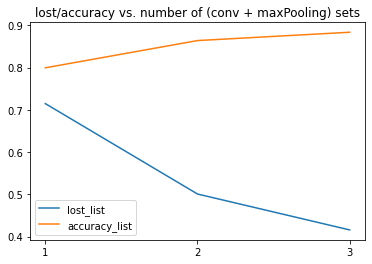

In [77]:
def compare_models(model_list, X_test, y_test):
    lost_list, accuracy_list = [None], [None]
    for m in model_list:
        lost, accuracy = m.evaluate(X_test,y_test) 
        lost_list.append(lost)
        accuracy_list.append(accuracy)

    plt.xticks(range(1,4))
    plt.plot(lost_list, label="lost_list") 
    plt.plot(accuracy_list, label="accuracy_list") 
    plt.legend()
    plt.title("lost/accuracy vs. number of (conv + maxPooling) layers")
    plt.show()

model_list = [model1, model2, model3]
compare_models(model_list, X_test, y_test)

* From the graph above, the more layers in the model, the higher accuracy. 
* The time of training models is proportional to the number of layers. 
* From the perspective of time efficiency and accuracy, we will choose 3 sets of convolutional and maxPooling layers in our model. 

### 3d. Colored vs Grayscale Input

In [81]:
# Create CNN model
model_colored = models.Sequential()
model_colored.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 3)))
model_colored.add(layers.MaxPooling2D((2, 2)))

model_colored.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_colored.add(layers.MaxPooling2D((2, 2)))

model_colored.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_colored.add(layers.MaxPooling2D((2, 2)))

model_colored.add(layers.Flatten()) 
model_colored.add(layers.Dense(64, activation='relu'))
model_colored.add(layers.Dense(10, activation='softmax'))

model_colored.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model_colored.fit(X_train_colored, y_train_colored, epochs=8)
model_colored.evaluate(X_test_colored,y_test_colored) 

Epoch 1/8
4575/4575 [==============================] - 60s 13ms/step - loss: 0.9270 - accuracy: 0.7322
Epoch 2/8
4575/4575 [==============================] - 59s 13ms/step - loss: 0.5959 - accuracy: 0.8256
Epoch 3/8
4575/4575 [==============================] - 59s 13ms/step - loss: 0.5141 - accuracy: 0.8493
Epoch 4/8
4575/4575 [==============================] - ETA: 0s - loss: 0.4700 - accuracy: 0.86 - 57s 12ms/step - loss: 0.4701 - accuracy: 0.8614
Epoch 5/8
4575/4575 [==============================] - 61s 13ms/step - loss: 0.4420 - accuracy: 0.8685
Epoch 6/8
4575/4575 [==============================] - 61s 13ms/step - loss: 0.4206 - accuracy: 0.8755
Epoch 7/8
4575/4575 [==============================] - 61s 13ms/step - loss: 0.4058 - accuracy: 0.8793
Epoch 8/8
813/813 [==============================] - 3s 4ms/step - loss: 0.5150 - accuracy: 0.8558


[0.5150416493415833, 0.855781078338623]

* There is no significant improvement in the accuracy of using the colored image.
* Classifying numbers are not related to color. The information from the grayscale image is enough for the classification.
* Colored input will have three feature maps instead of one from the grayscaled image, which will potentially increase the chance of overfitting. It also increased the cost of computing. 
* Thus, we will use the grayscaled images in the model traning& testing. 

## Step 4: Train & Test

In [86]:
# Optimized model
model = models.Sequential()
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten()) 
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [87]:
model.fit(X_train, y_train, epochs=8)
model.evaluate(X_test,y_test)
model.summary()

Epoch 1/8
4575/4575 [==============================] - 70s 15ms/step - loss: 0.8735 - accuracy: 0.7472
Epoch 2/8
4575/4575 [==============================] - 66s 14ms/step - loss: 0.5092 - accuracy: 0.8516
Epoch 3/8
4575/4575 [==============================] - 66s 14ms/step - loss: 0.4412 - accuracy: 0.8699
Epoch 4/8
4575/4575 [==============================] - 65s 14ms/step - loss: 0.4075 - accuracy: 0.8794
Epoch 5/8
4575/4575 [==============================] - 66s 14ms/step - loss: 0.3892 - accuracy: 0.8852
Epoch 6/8
4575/4575 [==============================] - 66s 14ms/step - loss: 0.3746 - accuracy: 0.8895
Epoch 7/8
4575/4575 [==============================] - 65s 14ms/step - loss: 0.3585 - accuracy: 0.8944
Epoch 8/8
813/813 [==============================] - 4s 4ms/step - loss: 0.3850 - accuracy: 0.8944
Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_60 (Conv2D)       

##### ---DIVIDER---

In [ ]:
y_pred = cnn_model.predict(X_test.astype('float64'))
print(y_pred)

In [ ]:
len(y_pred)

In [ ]:
#save model
cnn_model.save('./models')

In [ ]:
# group data by y_pred, y_test and img_number
print(y_pred.shape, y_test.shape, img_number.shape)

grouped_dict_pred = {}
grouped_dict_test = {}

for i in range(len(y_pred)):
    img = img_number[i]
    if img in grouped_dict_test:
        grouped_dict_test[img].append(y_test[i])
    else:
        grouped_dict_test[img] = [y_test[i]]
    
    if img in grouped_dict_pred:
        grouped_dict_pred[img].append(y_pred[i])
    else:
        grouped_dict_pred[img] = [y_pred[i]]

In [ ]:
# count successful predicted images and calculate the accuracy
cnt = 0
for i in img_number:
    if grouped_dict_pred[i] == grouped_dict_test[i]:
        cnt += 1

#Accuracy!
acc = cnt / len(img_number)
print("Accuracy for prediction is: ", acc)

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

labels = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]


In [ ]:
# Plot cropped image with predicted& actual labels
def plot_cropped_image(X, y, y_pred, idx):
    plt.imshow(X[idx])
    label = "actual:" + str(int(y[idx])) + "\npredicted:" + str(y_pred[idx])
    plt.xlabel(label)

image_index = 1
plot_cropped_image(X_test, y_test, y_pred, image_index)

In [ ]:
# Plot original image with predicted& actual labels
def display_image_with_pred(cnn_model, img_index, local_path):
    mode = "test"
    data = CropImage(local_path, mode)
    img_dir = data.get_cropped_image_path(img_index - 1)
    X = get_cropped_images(img_dir)
    y = get_labels(data, img_index - 1)
    y_pred = [np.argmax(y) for y in cnn_model.predict(np.array(X))]
    
    path = local_path + "/" + mode+"/" + str(img_index) + ".png"
    plt.imshow(img.imread(path))
    
    conclusion = "Correct Prediction" if y == y_pred else "Incorrect Prediction"
    label = "actual: " + str(y) + "\npredicted: " + str(y_pred) + "\n" + conclusion
    plt.xlabel(label)

    title = "{}.png".format(img_index)
    plt.title(title)

In [ ]:
img_index = 12 
display_image_with_pred(cnn_model, img_index, local_path)

## Step 5: Results and discussion

### 5a. Confusion Matrix

### 5b. Feature Maps